### Vertical scaling schemes for global runs

In [1]:
from scipy.stats import qmc
import numpy as np

import csv
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc4
import sys
import shutil
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                                                                                                                                                                       
import tempfile 
import random
import re

import scipy.optimize as opt

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm

import functions_py.fates_xarray_functions as fa


In [2]:
dark = cm.get_cmap('Dark2', 8)
colormap = dark(range(8))


### Load  data  from  Lamour et  al. 

In [3]:
data = pd.read_csv('/global/homes/j/jneedham/plot_data/Data_vertical_profiles_pfts.csv')
data = data[(data.Life_form != "LIANA") & (data.Life_form != "HEMIEPIPHYTIC VINE") & (data.Life_form != "HERB") & (data.Life_form) & (data.LAI) & (data.Rdark25) & (data.Vcmax25)]
data =  data.dropna(subset=['LAI', 'Rdark25', 'PFT', 'Vcmax25'])
print(data.head(3))

LD = data.loc[data['PFT'] == 'LD']
ST = data.loc[data['PFT'] == 'ST']

print(LD.shape)
print(ST.shape)


   Unnamed: 0 Vertical_Profile  Vertical_Elevation  Height    LAI   rd  \
0           1                A                   1    33.6  0.195  0.0   
3           4                B                   1    28.2  0.310  0.0   
4           5                C                   1    26.0  0.290  0.0   

              Species_Name    Life_form        Na         LMA        LWC  \
0       Apeiba membranacea  CANOPY TREE  3.880211  311.534757  47.829169   
3  Aspidosperma spruceanum  CANOPY TREE  3.033104  168.598699  56.534346   
4  Aspidosperma spruceanum  CANOPY TREE  3.863457  249.339440  51.597830   

     Vcmax25      Jmax25      Tp25   Rdark25 PFT  
0  66.232414  116.806517  8.515238  0.722623  LD  
3  51.468635  107.673173  7.350692  0.899975  ST  
4  72.197963  129.265249  8.277332  0.752589  ST  
(10, 16)
(108, 16)


### Function to fit parameters to Lamour data using Atkin respiration model

In [4]:
def func(x,a, b):
    return (a + b * x) * (1.7560 + 0.2061 * (0.033/0.018) + -0.0402 * max(0, (298.15 - 273.15)))

In [5]:
optimizedParameters, pcov = opt.curve_fit(func, data['LAI'], data['Rdark25'])

print(optimizedParameters)

lamour_a = optimizedParameters[0]
lamour_b = optimizedParameters[1]
       

[ 0.90060885 -0.08846473]


''

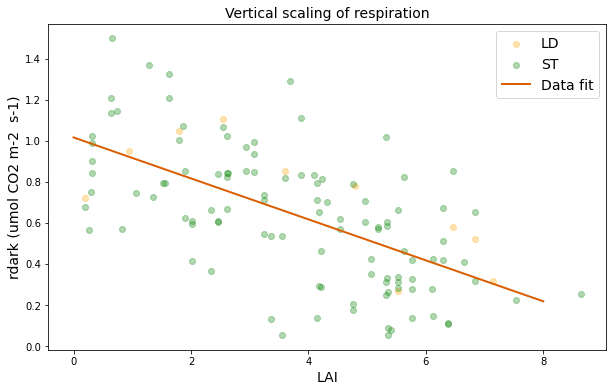

In [6]:
fig2, (f2ax0) = plt.subplots(nrows=1,ncols=1, figsize=(10,6))
 
f2ax0.scatter(LD['LAI'], LD['Rdark25'], alpha = 0.3, color='orange', label = 'LD')
f2ax0.scatter(ST['LAI'], ST['Rdark25'], alpha = 0.3, color='green', label = 'ST')

lai = np.linspace(0,8,9)
f2ax0.plot(lai, func(lai, *optimizedParameters), color=colormap[1], linewidth=2, label = 'Data fit')

f2ax0.set_title(r'Vertical scaling of respiration', fontsize = 14)
f2ax0.set_ylabel(r'rdark (umol CO2 m-2  s-1)', fontsize = 14)
f2ax0.set_xlabel(r'LAI', fontsize = 14) 
f2ax0.legend(fontsize=14)
;

In [7]:
lamour_BCI = func(lai, *optimizedParameters)
understory_rdark_lamour_BCI = lamour_BCI[-1]
print(understory_rdark_lamour_BCI)

0.21774498941488918


### Plot the three respiration curves - for each PFT

#### Constants

In [8]:
vcmax25tops  = [50, 62, 39, 61, 58, 58, 62, 54, 54, 78, 78, 78]
nitr_stoichs  = [0.033, 0.029, 0.04, 0.033, 0.04, 0.04, 0.033, 0.04, 0.04, 0.04, 0.04, 0.04]
slatops = [0.018, 0.006, 0.0288, 0.0108, 0.036, 0.036, 0.0144, 0.036, 0.036, 0.036, 0.036, 0.03]
lnc_tops =  [a / b for a,  b  in  zip(nitr_stoichs,  slatops)]
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0
tfrz = 273.15
veg_tempk = 298.15
r0s_def = [1.756, 1.4995, 1.4995, 1.756, 1.756, 1.756, 2.0749, 2.0749, 2.0749, 2.1956, 2.1956, 2.1956]
#r0s = [x  * 0.5  for x in  r0s_def]
#r0s = [1,1,1,1,1,1,1,1,1,1,1,1]
r0s = r0s_def
r1 = 0.2061
r2 = -0.0402
tgrowth = 298.15

In [9]:
# Since nscaler at  lai=0 is 1 we can replace lamour_a with 1

In [10]:
lamour_a = 1

In [11]:
r_t_refs_atkin = []
r_t_refs_lamour = []
r_t_refs_lloyd = []

lamour_slopes = []

for i in range(0,len(slatops)):
   
    kn = np.exp(0.00963 * vcmax25tops[i]  - 2.43)
    nscaler = np.exp(-kn * lai)
    
      # lloyd (v1)
    r_t_refs_lloyd.append(nscaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))) )
    
    # Atkin  (v2)
    lnc = lnc_tops[i] * nscaler
    r_t_refs_atkin.append( r0s[i] + r1 * lnc + r2 * max(0, (tgrowth - tfrz)) )

    # Lamour  (v3)
    def func(x,a, b):
        return (a + b * x) * (r0s[i] + r1 * (nitr_stoichs[i]/slatops[i]) + r2 * max(0, (tgrowth - tfrz)))

    optimizedParameters, pcov = opt.curve_fit(func, data['LAI'], data['Rdark25'])
    lamour_b = optimizedParameters[1]
    lamour_slopes.append(lamour_b)
    
    rdark_scaler = lamour_a + (lamour_b * lai)                                    
    r_t_refs_lamour.append( rdark_scaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))))

   


In [12]:
print(np.round(lamour_slopes,5))

[-0.08846 -0.06699 -0.12791 -0.07233 -0.1019  -0.1019  -0.06475 -0.07688
 -0.07688 -0.07035 -0.07035 -0.06815]


In [13]:
pftnames = ['broadleaf_evergreen_tropical_tree','needleleaf_evergreen_extratrop_tree',
         'needleleaf_colddecid_extratrop_tree','broadleaf_evergreen_extratrop_tree',
        'broadleaf_hydrodecid_tropical_tree','broadleaf_colddecid_extratrop_tree',
        'broadleaf_evergreen_extratrop_shrub','broadleaf_hydrodecid_extratrop_shrub',
        'broadleaf_colddecid_extratrop_shrub', 'arctic_c3_grass',
        'cool_c3_grasss','c4_grass']

''

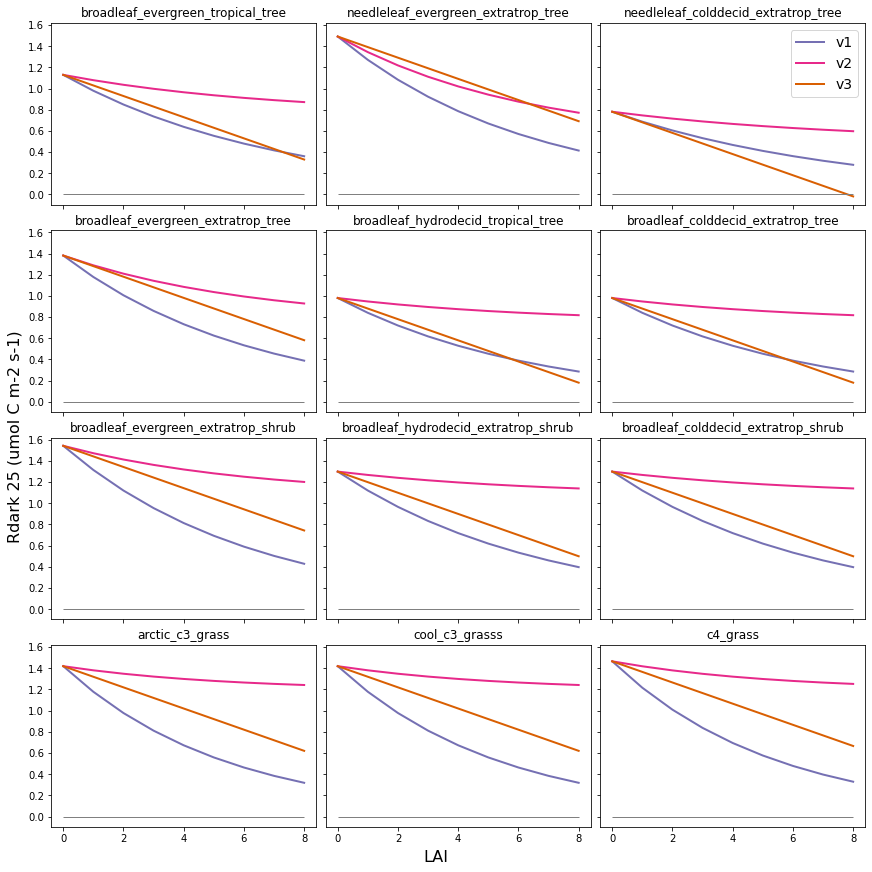

In [14]:
fig2, axs = plt.subplots(nrows=4, ncols=3, figsize=(12,12), sharex=True, sharey=True, constrained_layout=True)
    
axs = axs.flatten()    
   
for i in range(0,len(slatops)):   
    
    axs[i].plot(lai, r_t_refs_lloyd[i],  label = 'v1', color=colormap[2], linewidth=2)
    axs[i].plot(lai, r_t_refs_atkin[i],  label = 'v2', color=colormap[3], linewidth=2)
    axs[i].plot(lai, r_t_refs_lamour[i], label = 'v3', color=colormap[1], linewidth=2)
    axs[i].hlines(y=0, xmin=0, xmax=8, linewidth=1, color='grey')
    axs[i].set_title(pftnames[i])
    if  i == 2:     
        axs[i].legend(fontsize=14)
   

fig2.supxlabel(r'LAI', fontsize=16)
fig2.supylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize=16)

plt.savefig('/global/homes/j/jneedham/jupyter_notebooks/Resp_figs/S1_global_vert_pfts.png')
;

''

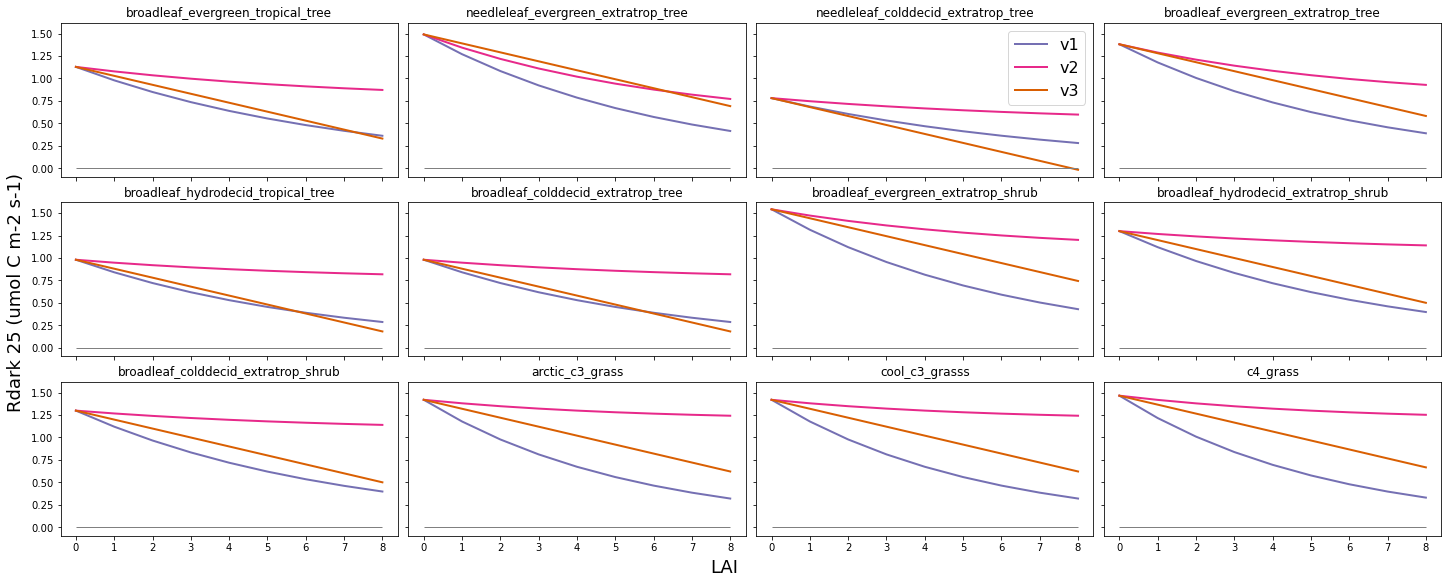

In [15]:
fig2, axs = plt.subplots(nrows=3, ncols=4, figsize=(20,8), sharex=True, sharey=True, constrained_layout=True)
    
axs = axs.flatten()    
   
for i in range(0,len(slatops)):   
    
    axs[i].plot(lai, r_t_refs_lloyd[i],  label = 'v1', color=colormap[2], linewidth=2)
    axs[i].plot(lai, r_t_refs_atkin[i],  label = 'v2', color=colormap[3], linewidth=2)
    axs[i].plot(lai, r_t_refs_lamour[i], label = 'v3', color=colormap[1], linewidth=2)
    axs[i].hlines(y=0, xmin=0, xmax=8, linewidth=1, color='grey')
    axs[i].set_title(pftnames[i])
    if  i == 2:     
        axs[i].legend(fontsize=16)
   

fig2.supxlabel(r'LAI', fontsize=18)
fig2.supylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize=18)

;

''

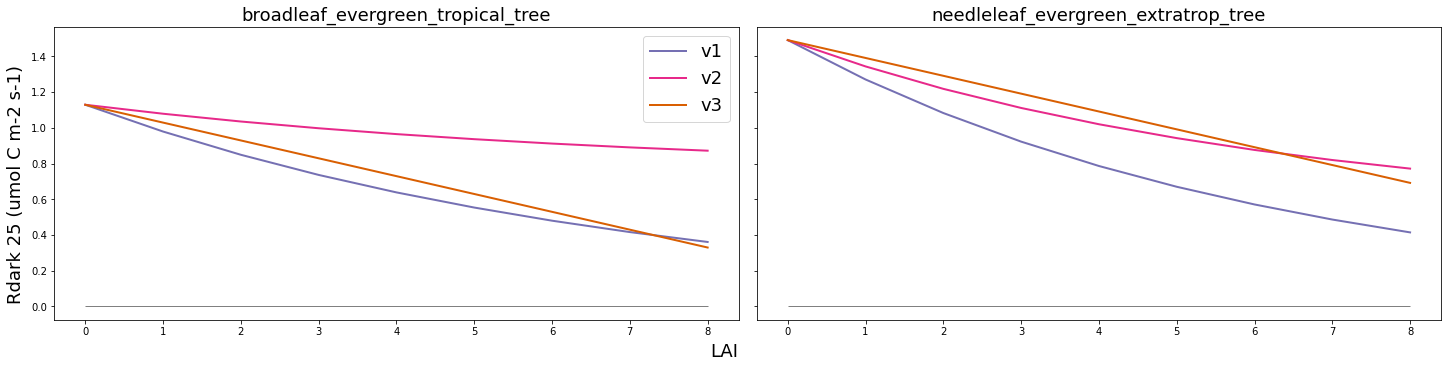

In [16]:
fig2, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5), sharex=True, sharey=True, constrained_layout=True)
    
axs = axs.flatten()    
   
for i in range(0,2):   
    
    axs[i].plot(lai, r_t_refs_lloyd[i],  label = 'v1', color=colormap[2], linewidth=2)
    axs[i].plot(lai, r_t_refs_atkin[i],  label = 'v2', color=colormap[3], linewidth=2)
    axs[i].plot(lai, r_t_refs_lamour[i], label = 'v3', color=colormap[1], linewidth=2)
    axs[i].hlines(y=0, xmin=0, xmax=8, linewidth=1, color='grey')
    axs[i].set_title(pftnames[i], fontsize=18)
    if  i == 0:     
        axs[i].legend(fontsize=18)
   

fig2.supxlabel(r'LAI', fontsize=18)
fig2.supylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize=18)

;

### Plot vertical scaling of vcmax - default FATES

In [17]:
lai = np.linspace(0,8,9)
kn = np.exp(0.00963 * 50  - 2.43)
nscaler = np.exp(-kn * lai)

''

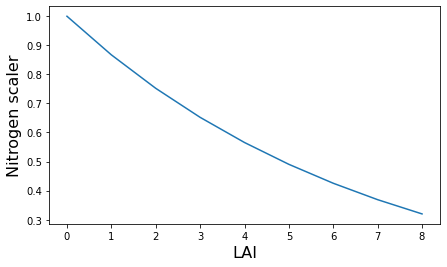

In [18]:
fig2, (f2ax0) = plt.subplots(nrows=1,ncols=1, figsize=(7,4))
 
f2ax0.plot(lai, nscaler)

f2ax0.set_ylabel(r'Nitrogen scaler', fontsize = 16)
f2ax0.set_xlabel(r'LAI', fontsize = 16) 

;

### Fix top of canopy and bottom of canopy Rdark in Lamour and find slope for each PFT

In other words, we are not fitting to data but rather  using the top of canopy leaf MR from Atkin for each PFT, and then finding the slope that would give the rdark obsesved at LAI of 8

In [19]:
r_t_refs_atkin = []
r_t_refs_lamour = []
r_t_refs_lloyd = []

lamour_slopes = []

for i in range(0,len(slatops)):
   
    kn = np.exp(0.00963 * vcmax25tops[i]  - 2.43)
    nscaler = np.exp(-kn * lai)
    
      # lloyd (v1)
    r_t_refs_lloyd.append(nscaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))) )
    
    # Atkin  (v2)
    lnc = lnc_tops[i] * nscaler
    r_t_refs_atkin.append( r0s[i] + r1 * lnc + r2 * max(0, (tgrowth - tfrz)) )

    # Lamour  (v3)
    def func(x, b) :
        return (1 + b * x)
    
    canopy_rdark_atkin = r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))
    
    
    optimizedParameters, pcov = opt.curve_fit(func, [0, 8], [canopy_rdark_atkin, understory_rdark_lamour_BCI])
    lamour_b = optimizedParameters[0]
    print(lamour_b)
    lamour_slopes.append(lamour_b)
    
    rdark_scaler = lamour_a + (lamour_b * lai)                                    
    r_t_refs_lamour.append( rdark_scaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))))

   


-0.09778187632553337
-0.09778187632553337
-0.09778187632553337
-0.09778187632553337
-0.09778187632553337
-0.09778187632553337
-0.09778187632553337
-0.09778187632553337
-0.09778187632553337
-0.09778187632553337
-0.09778187632553337
-0.09778187632553337


Text(0.02, 0.5, 'Rdark 25 (umol C m-2 s-1)')

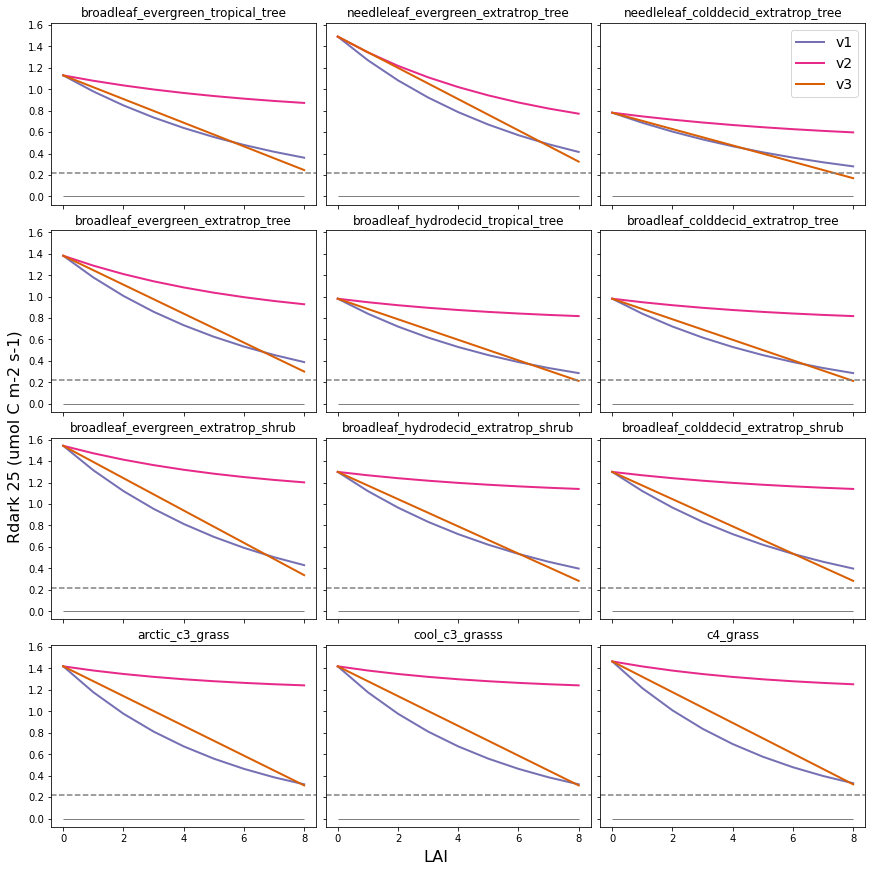

In [20]:
fig2, axs = plt.subplots(nrows=4, ncols=3, figsize=(12,12), sharex=True, sharey=True, constrained_layout=True)
    
axs = axs.flatten()    
   
for i in range(0,len(slatops)):   
    
    axs[i].plot(lai, r_t_refs_lloyd[i],  label = 'v1', color=colormap[2], linewidth=2)
    axs[i].plot(lai, r_t_refs_atkin[i],  label = 'v2', color=colormap[3], linewidth=2)
    axs[i].plot(lai, r_t_refs_lamour[i], label = 'v3', color=colormap[1], linewidth=2)
    axs[i].hlines(y=0, xmin=0, xmax=8, linewidth=1, color='grey')
    axs[i].set_title(pftnames[i])
    axs[i].axhline(y=understory_rdark_lamour_BCI, color='grey', linestyle='--')
    if  i == 2:     
        axs[i].legend(fontsize=14)
   

fig2.supxlabel(r'LAI', fontsize=16)
fig2.supylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize=16)



### Try lloyd scaling but steeper

In [21]:
steep_kn1 = 2.43 * 1.2
print(steep_kn1)
steep_kn2 = 2.43 * 1.1
print(steep_kn2)
steep_kn3 = 2.43 * 1
print(steep_kn3)
steep_kn4 = 2.43 * 0.9
print(steep_kn4)
steep_kn5 = 2.43 * 0.8
print(steep_kn5)
steep_kn6 = 2.43 * 0.7
print(steep_kn6)
steep_kn7 = 2.43 * 0.6
print(steep_kn7)
steep_kn8 = 2.43 * 0.5
print(steep_kn8)

2.916
2.6730000000000005
2.43
2.1870000000000003
1.9440000000000002
1.701
1.458
1.215


In [22]:
r_t_refs_steep_lloyd1 = []
r_t_refs_steep_lloyd2 = []
r_t_refs_steep_lloyd3 = []
r_t_refs_steep_lloyd4 = []
r_t_refs_steep_lloyd5 = []
r_t_refs_steep_lloyd6 = []
r_t_refs_steep_lloyd7 = []
r_t_refs_steep_lloyd8 = []

for i in range(0,len(slatops)):
    
    # lloyd steep (v1)
    kn = np.exp(0.00963 * vcmax25tops[i]  - steep_kn1)
    nscaler = np.exp(-kn * lai)
    r_t_refs_steep_lloyd1.append(nscaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))) )
    
    # lloyd steep (v2)
    kn = np.exp(0.00963 * vcmax25tops[i]  - steep_kn2)
    nscaler = np.exp(-kn * lai)
    r_t_refs_steep_lloyd2.append(nscaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))) )
    
    # lloyd steep (v3)
    kn = np.exp(0.00963 * vcmax25tops[i]  - steep_kn3)
    nscaler = np.exp(-kn * lai)
    r_t_refs_steep_lloyd3.append(nscaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))) )
    
     # lloyd steep (v4)
    kn = np.exp(0.00963 * vcmax25tops[i]  - steep_kn4)
    nscaler = np.exp(-kn * lai)
    r_t_refs_steep_lloyd4.append(nscaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))) )
    
     # lloyd steep (v5)
    kn = np.exp(0.00963 * vcmax25tops[i]  - steep_kn5)
    nscaler = np.exp(-kn * lai)
    r_t_refs_steep_lloyd5.append(nscaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))) )
    
     # lloyd steep (v6)
    kn = np.exp(0.00963 * vcmax25tops[i]  - steep_kn6)
    nscaler = np.exp(-kn * lai)
    r_t_refs_steep_lloyd6.append(nscaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))) )
    
     # lloyd steep (v7)
    kn = np.exp(0.00963 * vcmax25tops[i]  - steep_kn7)
    nscaler = np.exp(-kn * lai)
    r_t_refs_steep_lloyd7.append(nscaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))) )
    
     # lloyd steep (v8)
    kn = np.exp(0.00963 * vcmax25tops[i]  - steep_kn8)
    nscaler = np.exp(-kn * lai)
    r_t_refs_steep_lloyd8.append(nscaler * (r0s[i] + r1 * lnc_tops[i] + r2 * max(0, (tgrowth - tfrz))) )
    

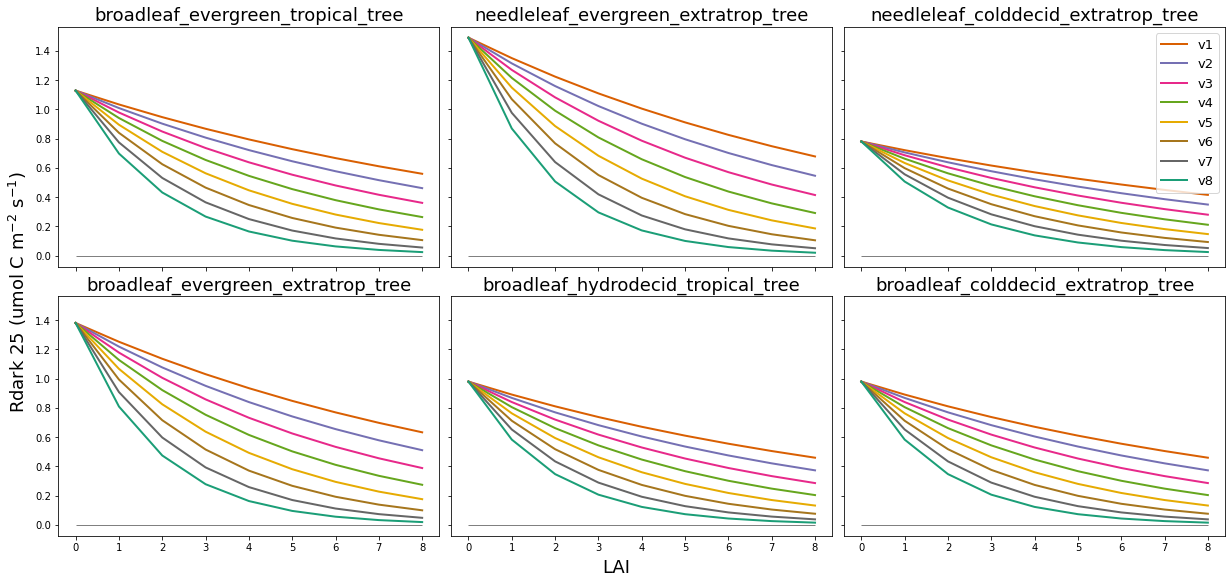

In [23]:
fig2, axs = plt.subplots(nrows=2, ncols=3, figsize=(17,8), sharex=True, sharey=True, constrained_layout=True)
    
axs = axs.flatten()    
   
for i in range(0,6):   
    
    axs[i].plot(lai, r_t_refs_steep_lloyd1[i], label = 'v1', color=colormap[1], linewidth=2)
    axs[i].plot(lai, r_t_refs_steep_lloyd2[i], label = 'v2', color=colormap[2], linewidth=2)
    axs[i].plot(lai, r_t_refs_steep_lloyd3[i], label = 'v3', color=colormap[3], linewidth=2)
    axs[i].plot(lai, r_t_refs_steep_lloyd4[i], label = 'v4', color=colormap[4], linewidth=2)
    axs[i].plot(lai, r_t_refs_steep_lloyd5[i], label = 'v5', color=colormap[5], linewidth=2)
    axs[i].plot(lai, r_t_refs_steep_lloyd6[i], label = 'v6', color=colormap[6], linewidth=2)
    axs[i].plot(lai, r_t_refs_steep_lloyd7[i], label = 'v7', color=colormap[7], linewidth=2)
    axs[i].plot(lai, r_t_refs_steep_lloyd8[i], label = 'v8', color=colormap[0], linewidth=2)
    axs[i].hlines(y=0, xmin=0, xmax=8, linewidth=1, color='grey')
    axs[i].set_title(pftnames[i], fontsize=18)
    if  i == 2:     
        axs[i].legend(fontsize=13)

fig2.supxlabel(r'LAI', fontsize=18)
fig2.supylabel(r'Rdark 25 (umol C m$^{-2}$ s$^{-1}$)', fontsize=18)

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Vertical_gradients_Rdark', 
            bbox_inches='tight', facecolor='white')

plt.savefig('/global/homes/j/jneedham/Rdark_vert_figs/Vertical_gradients_Rdark.pdf', 
            bbox_inches='tight', facecolor='white')    

Text(0.02, 0.5, 'Rdark 25 (umol C m-2 s-1)')

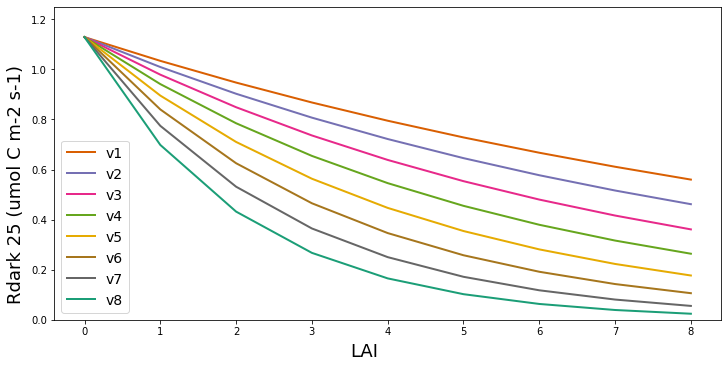

In [24]:
i = 0
fig2, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)
  
axs.plot(lai, r_t_refs_steep_lloyd1[i], label = 'v1', color=colormap[1], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd2[i], label = 'v2', color=colormap[2], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd3[i], label = 'v3', color=colormap[3], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd4[i], label = 'v4', color=colormap[4], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd5[i], label = 'v5', color=colormap[5], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd6[i], label = 'v6', color=colormap[6], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd7[i], label = 'v7', color=colormap[7], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd8[i], label = 'v8', color=colormap[0], linewidth=2)

#axs.hlines(y=0, xmin=0, xmax=8, linewidth=1, color='grey')
axs.set_title('')
axs.legend(fontsize=14)
axs.set_ylim(0,1.25)

fig2.supxlabel(r'LAI', fontsize=18)
fig2.supylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize=18)



In [25]:
print(r_t_refs_steep_lloyd3[0])

[1.12885    0.97893677 0.84893227 0.7361926  0.63842495 0.55364101
 0.48011653 0.41635622 0.36106339]


In [26]:
print(r_t_refs_steep_lloyd6[0])

[1.12885    0.840147   0.62527969 0.46536462 0.34634778 0.25776945
 0.19184501 0.14278071 0.10626459]


In [27]:
new  = r_t_refs_steep_lloyd6[0][-1]
control = r_t_refs_steep_lloyd3[0][-1]

print((control - new)/control * 100)

70.568993033505


In [28]:
print(new)
print(control)

0.10626459287131326
0.3610633947805033


In [29]:
print(new/control * 100)

29.431006966494998


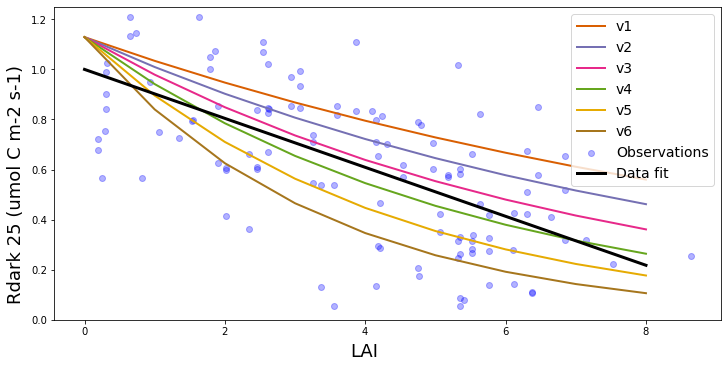

In [30]:
i = 0
fig2, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)
  
axs.plot(lai, r_t_refs_steep_lloyd1[i], label = 'v1', color=colormap[1], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd2[i], label = 'v2', color=colormap[2], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd3[i], label = 'v3', color=colormap[3], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd4[i], label = 'v4', color=colormap[4], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd5[i], label = 'v5', color=colormap[5], linewidth=2)
axs.plot(lai, r_t_refs_steep_lloyd6[i], label = 'v6', color=colormap[6], linewidth=2)

#axs.hlines(y=0, xmin=0, xmax=8, linewidth=1, color='grey')
axs.set_title('')

axs.set_ylim(0,1.25)


axs.scatter(data['LAI'], data['Rdark25'], alpha = 0.3, color='blue', label = 'Observations')
#axs.scatter(ST['LAI'], ST['Rdark25'], alpha = 0.3, color='green', label = 'ST')
axs.plot(lai, func(lai, *optimizedParameters), color='black', linewidth=3, label = 'Data fit')

fig2.supxlabel(r'LAI', fontsize=18)
fig2.supylabel(r'Rdark 25 (umol C m-2 s-1)', fontsize=18)
axs.legend(fontsize=14)


### For single site simulations - two PFTs, 8 parameterizations, four vertical scaling schemes